In [1]:
import os
import torch
import numpy as np
import pandas as pd
import sensorium
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from nnfabrik.builder import get_data, get_model, get_trainer
import matplotlib.pyplot as plt

## Functions that are used to calculate the oracle correlation

In [2]:
def get_data_filetree_loader(filename=None, dataloader=None, tier="test"):
    """
    Extracts necessary data for model evaluation from a dataloader based on the FileTree dataset.

    Args:
        filename (str): Specifies a path to the FileTree dataset.
        dataloader (obj): PyTorch Dataloader

    Returns:
        tuple: Contains:
               - trial indices (1D array)
               - image IDs (1D array)
               - neuron IDs (1D array)
               - responses (2d array: trials x neurons)
    """

    if dataloader is None:
        dataset_fn = "sensorium.datasets.static_loaders"
        dataset_config = {'paths': filename,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':0.25,
                 }

        dataloaders = get_data(dataset_fn, dataset_config)
        data_key = list(dataloaders[tier].keys())[0]

        dat = dataloaders[tier][data_key].dataset
    else:
        dat = dataloader.dataset

    neuron_ids = dat.neurons.unit_ids.tolist()
    tiers = dat.trial_info.tiers
    complete_image_ids = dat.trial_info.frame_image_id
    complete_trial_idx = dat.trial_info.trial_idx

    trial_indices, responses, image_ids = [], [], []
    for i, datapoint in enumerate(dat):
        if tiers[i] != tier:
            continue

        trial_indices.append(complete_trial_idx[i])
        image_ids.append(complete_image_ids[i])
        responses.append(datapoint.responses.cpu().numpy().squeeze())

    responses = np.stack(responses)

    return trial_indices, image_ids, neuron_ids, responses


def corr(
    y1, y2, axis, eps: int = 1e-8, **kwargs
) -> np.ndarray:
    """
    Compute the correlation between two NumPy arrays along the specified dimension(s).

    Args:
        y1:      first NumPy array
        y2:      second NumPy array
        axis:    dimension(s) along which the correlation is computed. Any valid NumPy axis spec works here
        eps:     offset to the standard deviation to avoid exploding the correlation due to small division (default 1e-8)
        **kwargs: passed to final numpy.mean operation over standardized y1 * y2

    Returns: correlation array
    """

    y1 = (y1 - y1.mean(axis=axis, keepdims=True)) / (y1.std(axis=axis, keepdims=True, ddof=0) + eps)
    y2 = (y2 - y2.mean(axis=axis, keepdims=True)) / (y2.std(axis=axis, keepdims=True, ddof=0) + eps)
    return (y1 * y2).mean(axis=axis, **kwargs)

def compute_oracle_corr(repeated_outputs):
    if len(repeated_outputs.shape) == 3:
        _, r, n = repeated_outputs.shape
        oracles = (repeated_outputs.mean(axis=1, keepdims=True) - repeated_outputs / r) * r / (r - 1)
        if np.any(np.isnan(oracles)):
            warnings.warn(
                "{}% NaNs when calculating the oracle. NaNs will be set to Zero.".format(np.isnan(oracles).mean() * 100)
            )
        oracles[np.isnan(oracles)] = 0
        return corr(oracles.reshape(-1, n), repeated_outputs.reshape(-1, n), axis=0)
    else:
        oracles = []
        for outputs in repeated_outputs:
            r, n = outputs.shape
            # compute the mean over repeats, for each neuron
            mu = outputs.mean(axis=0, keepdims=True)
            # compute oracle predictor
            oracle = (mu - outputs / r) * r / (r - 1)

            if np.any(np.isnan(oracle)):
                warnings.warn(
                    "{}% NaNs when calculating the oracle. NaNs will be set to Zero.".format(
                        np.isnan(oracle).mean() * 100
                    )
                )
                oracle[np.isnan(oracle)] = 0

            oracles.append(oracle)
        return corr(np.vstack(repeated_outputs), np.vstack(oracles), axis=0)

## Calculating the oracle correlation for the 2022 sensorium datasets

In [3]:
basepath = "../data/sensorium_data2022/"

filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]

dataset_fn = 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':.25,
                 }

dataloaders = get_data(dataset_fn, dataset_config)

In [4]:
files = []
for filename in filenames:
    files.append([filename,])

In [5]:
trial_indices = []
image_ids = []
neuron_ids = []
responses = []
for filename in tqdm(files):
    trial_indices_temp, image_ids_temp, neuron_ids_temp, responses_temp = get_data_filetree_loader(filename=filename)
    trial_indices.append(trial_indices_temp)
    image_ids.append(image_ids_temp)
    neuron_ids.append(neuron_ids_temp)
    responses.append(responses_temp)

100%|██████████| 5/5 [00:42<00:00,  8.44s/it]


In [6]:
repeated_outputs = []
for i in range(len(responses)):
    neurons_or = []
    for j in range(100):

        neuron_temp = responses[i][(j)*10:(j+1)*10]
        neurons_or.append(neuron_temp)
    repeated_outputs.append(neurons_or)

In [8]:
#Getting all batches to the same dimension.
repeated_outputs[0].pop()
repeated_outputs[1].pop()
repeated_outputs[2].pop()
repeated_outputs[3].pop()
repeated_outputs[4].pop()
repeated_outputs[4].pop()

array([[2.78297154e-08, 1.93981431e-09, 8.20936918e-09, ...,
        5.90259752e-09, 1.71507239e-01, 2.28552621e-09],
       [1.11005015e-07, 1.37470986e-08, 1.66168579e-09, ...,
        7.47048006e-08, 8.63470273e-09, 2.39516496e-09],
       [1.59314362e-09, 1.48625678e-09, 5.74041092e-10, ...,
        1.76565997e-08, 1.04986264e-09, 2.27554438e-08],
       ...,
       [3.62209391e-08, 1.02900577e+00, 7.51554668e-01, ...,
        2.63294231e-09, 1.21495519e-02, 7.45682893e-09],
       [5.38623368e-08, 2.60514010e-08, 3.66424153e-08, ...,
        4.08575884e-09, 7.69690800e-08, 4.16364099e-09],
       [4.60827142e-01, 1.08328759e-08, 2.00048802e-07, ...,
        7.26974037e-09, 3.56599514e-08, 5.63882113e-01]], dtype=float32)

## Calculating the oracle correlation for the new data

In [9]:
basepath_new = "../data/new_data2023/"
filenames_new = [os.path.join(basepath_new, file) for file in os.listdir(basepath_new) if ".zip" in file ]

In [10]:
files_new = []
for filename in filenames_new:
    files_new.append([filename,])

In [11]:
trial_indices_new = []
image_ids_new = []
neuron_ids_new = []
responses_new = []
for filename in files_new:
    trial_indices_temp, image_ids_temp, neuron_ids_temp, responses_temp = get_data_filetree_loader(filename=filename)
    trial_indices_new.append(trial_indices_temp)
    image_ids_new.append(image_ids_temp)
    neuron_ids_new.append(neuron_ids_temp)
    responses_new.append(responses_temp)

In [12]:
repeated_outputs_new = []
for i in range(len(responses_new)):
    neurons_or = []
    for j in range(200):

        neuron_temp = responses_new[i][(j)*10:(j+1)*10]
        neurons_or.append(neuron_temp)
    repeated_outputs_new.append(neurons_or)

In [13]:
repeated_outputs_new[0].pop()

array([[5.0901085e-01, 7.0915401e-02, 1.1630266e-07, ..., 7.2530843e-03,
        6.2111743e-02, 1.4995595e-09],
       [1.4159763e-01, 1.0827284e+00, 2.2268088e-08, ..., 1.1116653e-03,
        4.0774330e-01, 9.1130674e-02],
       [4.6607029e-01, 1.6372397e-08, 3.4056216e-02, ..., 6.4202457e-09,
        1.1130924e-02, 9.3170511e-09],
       [1.9757509e-01, 1.2588245e-01, 1.6006641e-07, ..., 1.3214003e+00,
        8.1565917e-01, 6.7649224e-09],
       [6.0626358e-01, 2.8068410e-02, 1.2757809e-01, ..., 1.6347351e-02,
        2.4491552e-02, 4.9945205e-02],
       [1.1431665e+00, 7.3343474e-01, 2.2406913e-03, ..., 1.7724309e-02,
        1.1796322e-01, 6.3248858e-02]], dtype=float32)

## Plotting the mean oracle correlation across all neuros for each model of the sensorium competition 2022.

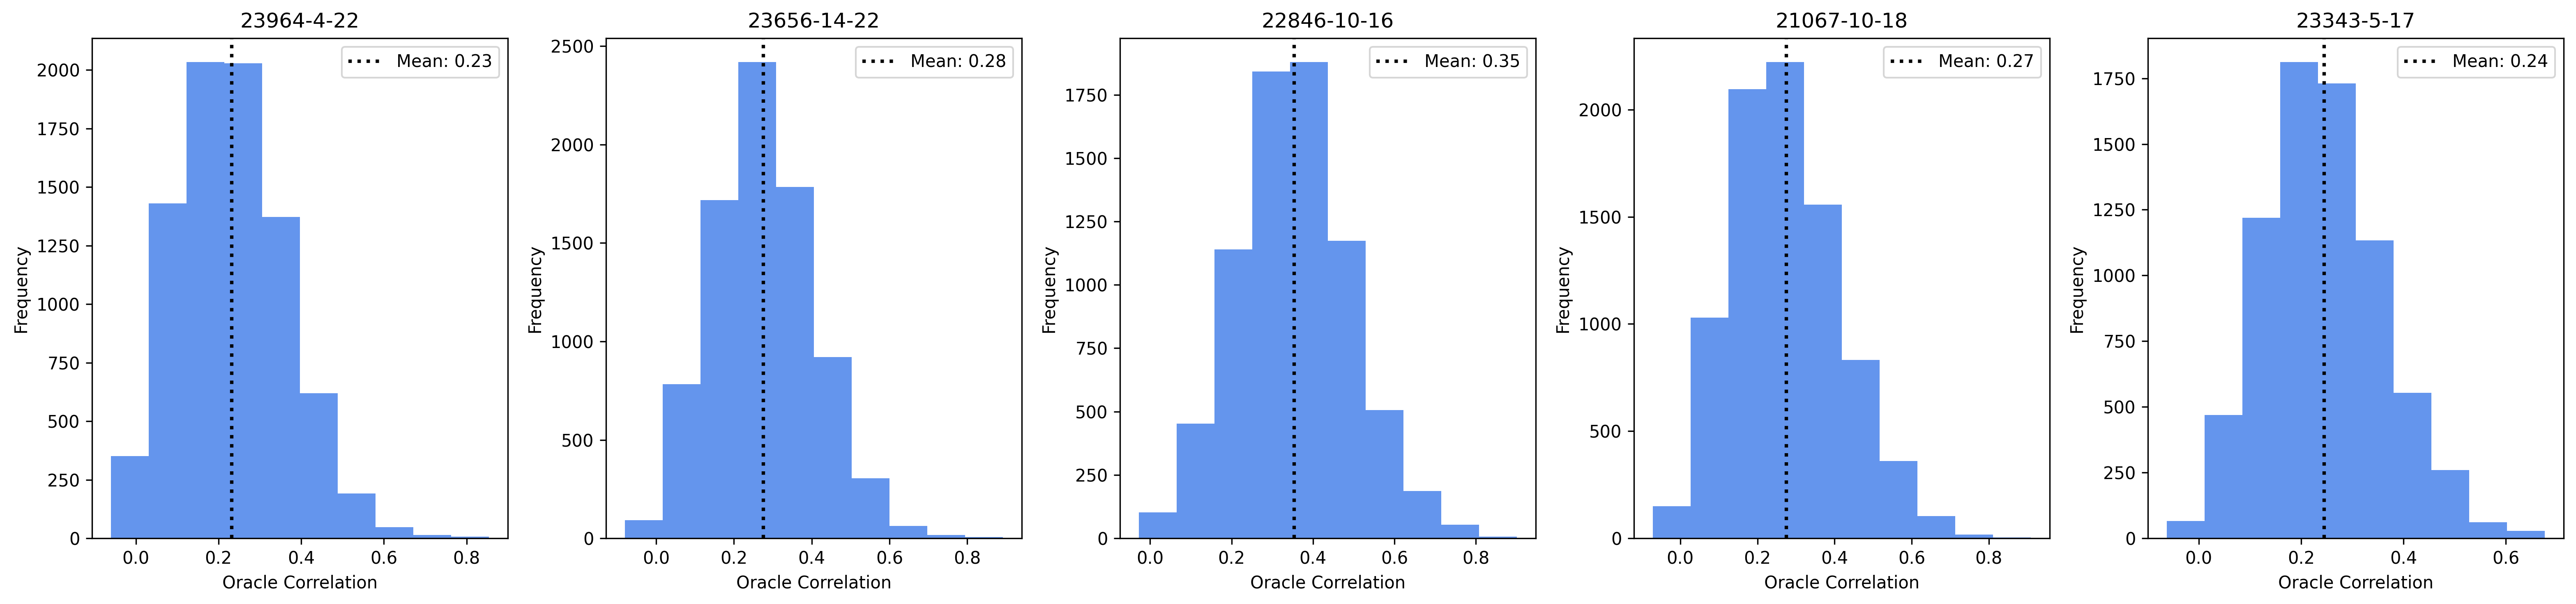

In [14]:
dataset_titles = ["23964-4-22", "23656-14-22", "22846-10-16", "21067-10-18", "23343-5-17"]
fig, axs = plt.subplots(1,5,figsize=(21,5), dpi=300)
for i in range(len(repeated_outputs)):
    oracle_corr_mean = np.mean(compute_oracle_corr(np.array(repeated_outputs[i])))
    axs[i].hist(compute_oracle_corr(np.array(repeated_outputs[i])), color="cornflowerblue")
    axs[i].axvline(oracle_corr_mean, color='k', linestyle='dotted', linewidth=2, label=f'Mean: {oracle_corr_mean:.2f}')
    axs[i].set_title(dataset_titles[i])
    axs[i].set_xlabel("Oracle Correlation")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()
plt.tight_layout()
fig.savefig("Plots/OracleCorrelationsSensorium.png", dpi=300)
plt.show()


## Plotting the mean oracle correlation across all neuros for the autistic and wild-type model.

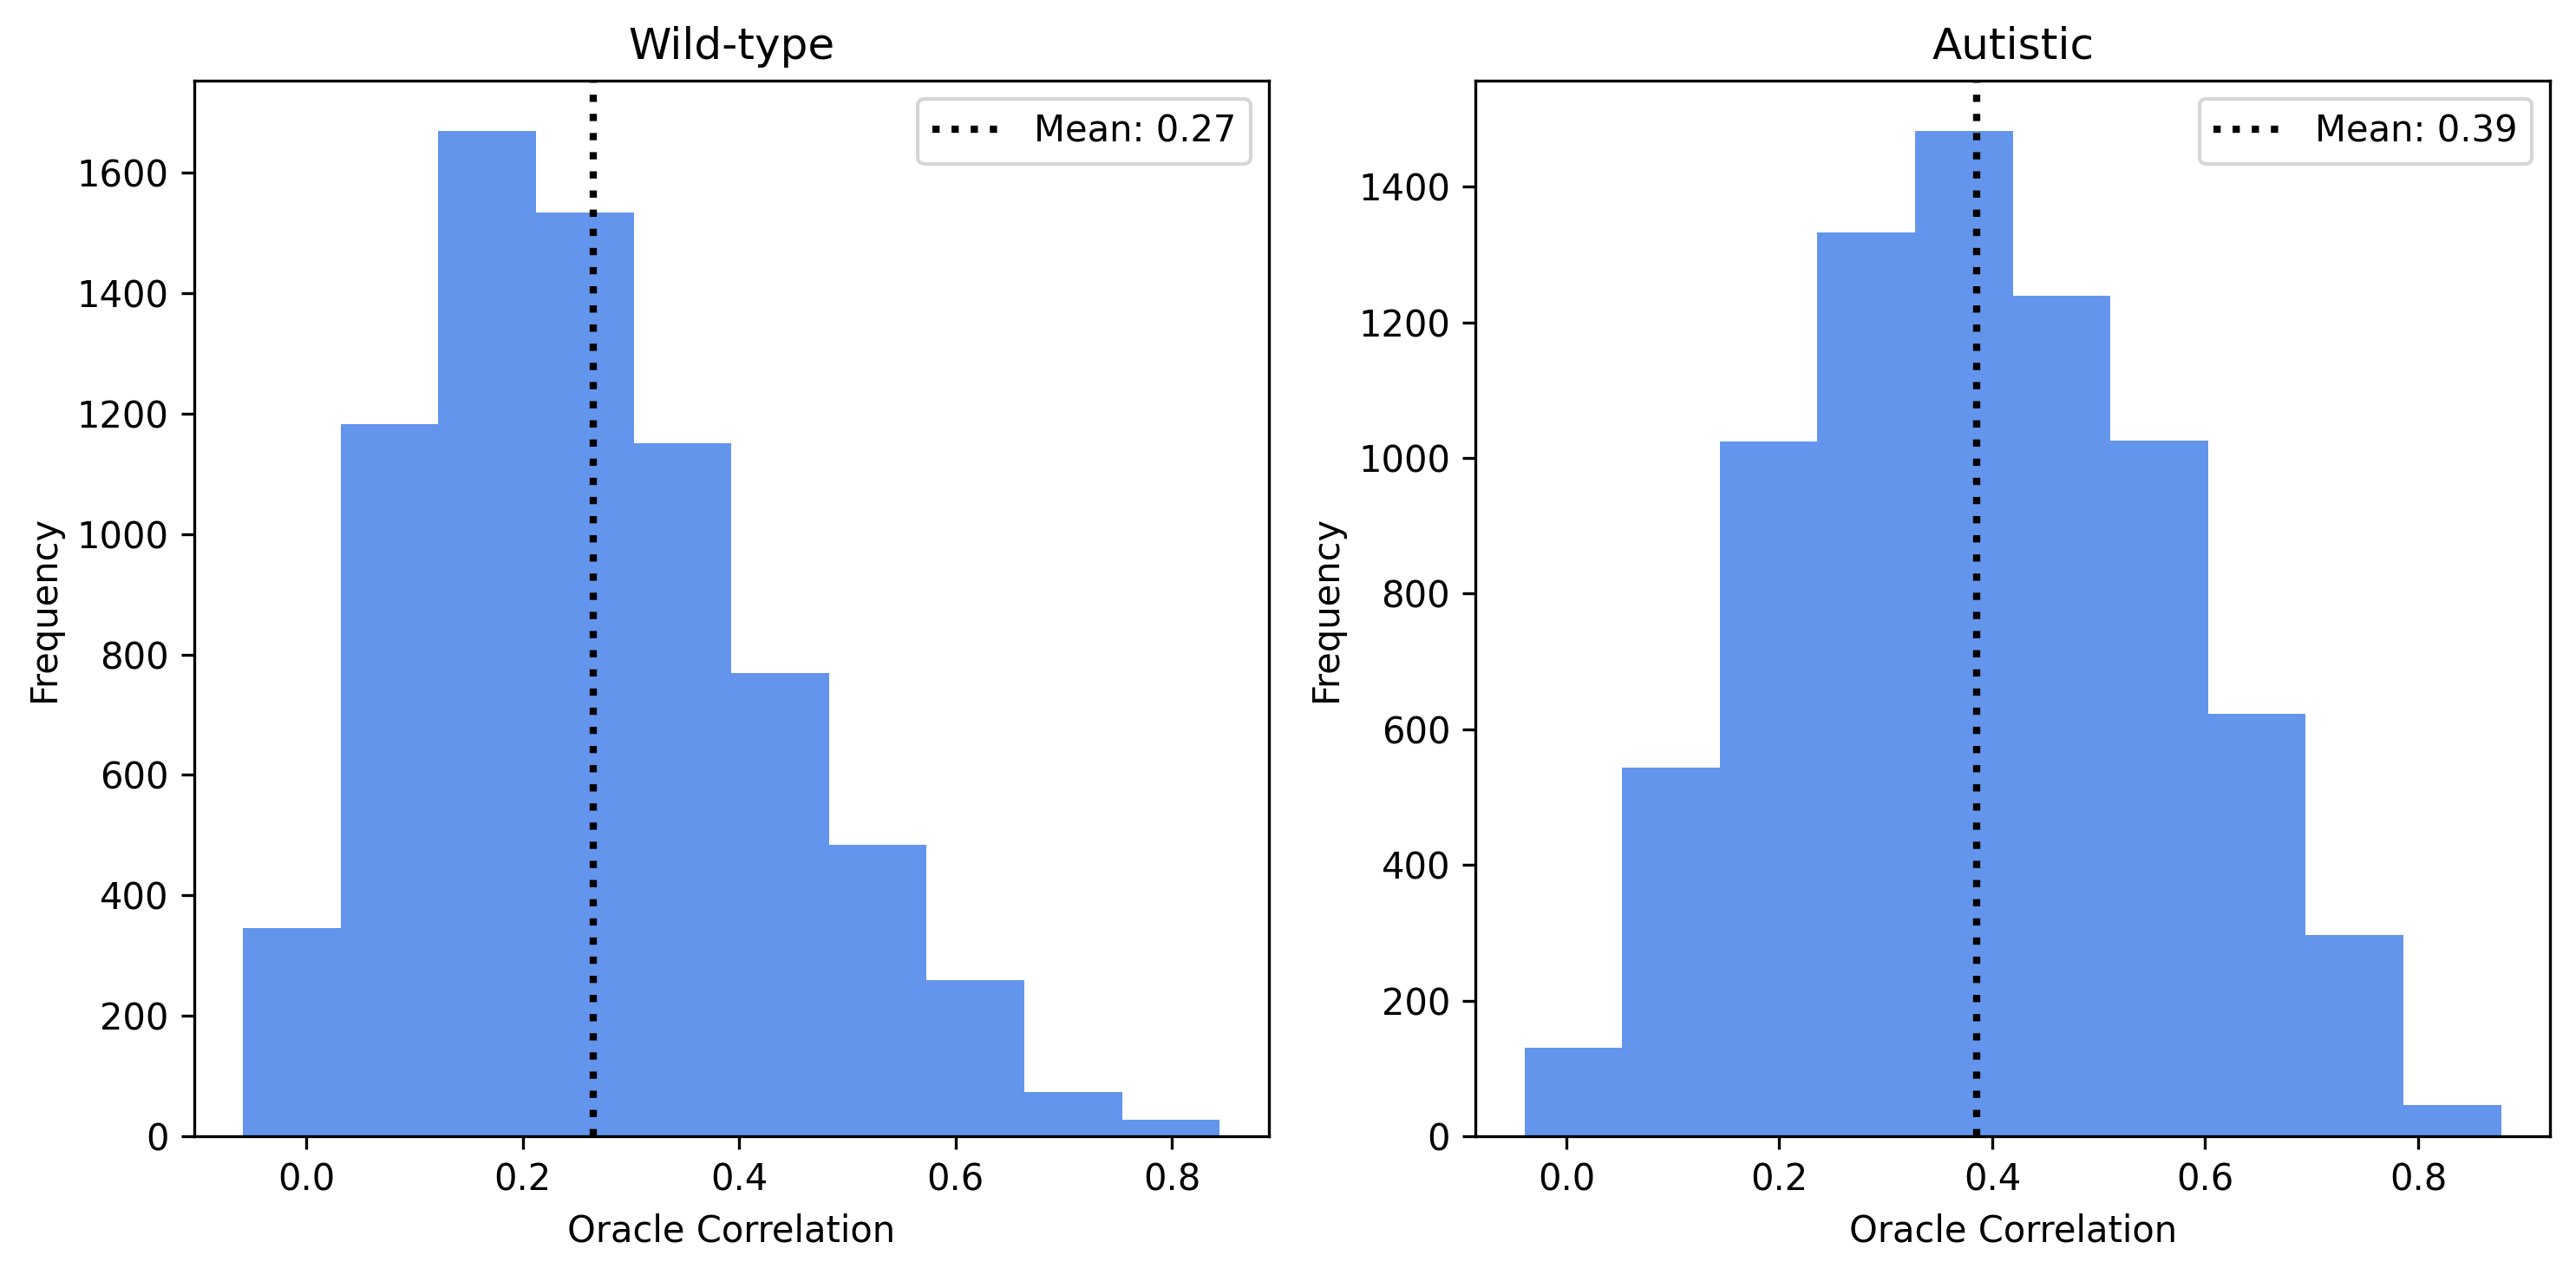

In [15]:
dataset_titles_new = ["Wild-type", "Autistic"]
fig, axs = plt.subplots(1,2,figsize=(10,5), dpi=300)
for i in range(len(repeated_outputs_new)):
    oracle_corr_mean = np.mean(compute_oracle_corr(np.array(repeated_outputs_new[i])))
    axs[i].hist(compute_oracle_corr(np.array(repeated_outputs_new[i])), color="cornflowerblue")
    axs[i].axvline(oracle_corr_mean, color='k', linestyle='dotted', linewidth=2, label=f'Mean: {oracle_corr_mean:.2f}')
    axs[i].set_title(dataset_titles_new[i])
    axs[i].set_xlabel("Oracle Correlation")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()
plt.tight_layout()
fig.savefig("Plots/OracleCorrelationsNewData.png", dpi=300)
plt.show()